In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from setting.setting import *  # Giả định rằng file setting chứa các đường dẫn như PROCESSED_TRAIN_DIR

In [2]:
data_dir = "../../dataset/processed/v1/training"
val_data_dir = "../../dataset/processed/v1/validation"
model_dir = "../../models/MobileNetV2"
best_model_filename = 'mobilenetv2_best_model_v1.keras'  # Tên file mô hình tốt nhất


# Tạo thư mục lưu mô hình nếu chưa tồn tại
os.makedirs(model_dir, exist_ok=True)

In [3]:
# Tải và chuẩn hóa dữ liệu huấn luyện
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # Nhãn dạng one-hot cho 26 lớp
).map(lambda x, y: (x / 255.0, y))  # Chuẩn hóa pixel về [0, 1]

# Tải và chuẩn hóa dữ liệu validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
).map(lambda x, y: (x / 255.0, y))

Found 21945 files belonging to 26 classes.
Found 2465 files belonging to 26 classes.


In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Lật ngang ngẫu nhiên
    tf.keras.layers.RandomZoom(0.1),  # Zoom ngẫu nhiên với biên độ 10%
    tf.keras.layers.RandomRotation(0.1),  # Xoay ngẫu nhiên với góc tối đa 10%
])

In [5]:
# Áp dụng augmentation cho tập huấn luyện
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

# Tăng tốc xử lý dữ liệu bằng prefetch
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [6]:
# Tải MobileNetV2 làm base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Đóng băng các lớp của MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Xây dựng mô hình hoàn chỉnh
model = Sequential([
    base_model,  # Sử dụng MobileNetV2 làm nền tảng
    Flatten(),  # Chuyển tensor thành vector
    Dense(256, activation='relu'),  # Lớp fully connected với 256 units
    Dropout(0.5),  # Giảm overfitting
    Dense(26, activation='softmax')  # Lớp đầu ra cho 26 ký tự ASL
])

NameError: name 'img_height' is not defined

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate thấp để hội tụ ổn định
    loss='categorical_crossentropy',  # Loss function cho phân loại đa lớp
    metrics=['accuracy']  # Đánh giá bằng độ chính xác
)

In [8]:
# EarlyStopping để dừng sớm nếu không cải thiện
early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi validation loss
    patience=5,  # Dừng sau 5 epochs nếu không cải thiện
    mode='min',
    verbose=1
)

# ModelCheckpoint để lưu mô hình tốt nhất
checkpoint = ModelCheckpoint(
    os.path.join(model_dir, best_model_filename),  # Đường dẫn lưu file
    monitor='val_accuracy',  # Theo dõi validation accuracy
    save_best_only=True,  # Chỉ lưu mô hình tốt nhất
    mode='max',
    verbose=1
)

In [9]:
final_total_epochs = 100  # Số epochs tối đa
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=final_total_epochs,
    callbacks=[early_stopping, checkpoint],  # Áp dụng callbacks
    verbose=1  # Hiển thị tiến trình huấn luyện
)

Epoch 1/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.6438 - loss: 1.3088
Epoch 1: val_accuracy improved from -inf to 0.97606, saving model to ../models\mobilenetv2_best_model_224x224.keras
686/686 ━━━━━━━━━━━━━━━━━━━━ 785s 1s/step - accuracy: 0.6440 - loss: 1.3080 - val_accuracy: 0.9761 - val_loss: 0.0833
Epoch 2/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9071 - loss: 0.3103
Epoch 2: val_accuracy improved from 0.97606 to 0.98296, saving model to ../models\mobilenetv2_best_model_224x224.keras
686/686 ━━━━━━━━━━━━━━━━━━━━ 856s 1s/step - accuracy: 0.9072 - loss: 0.3103 - val_accuracy: 0.9830 - val_loss: 0.0572
Epoch 3/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.9334 - loss: 0.2209
Epoch 3: val_accuracy improved from 0.98296 to 0.98540, saving model to ../models\mobilenetv2_best_model_224x224.keras
686/686 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - accuracy: 0.9334 - loss: 0.2209 - val_accuracy: 0.9854 - val_loss: 0.0471
Epoch 4/100
686/686 ━━━━━━━━

In [10]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../models\mobilenetv2_best_model_224x224.keras


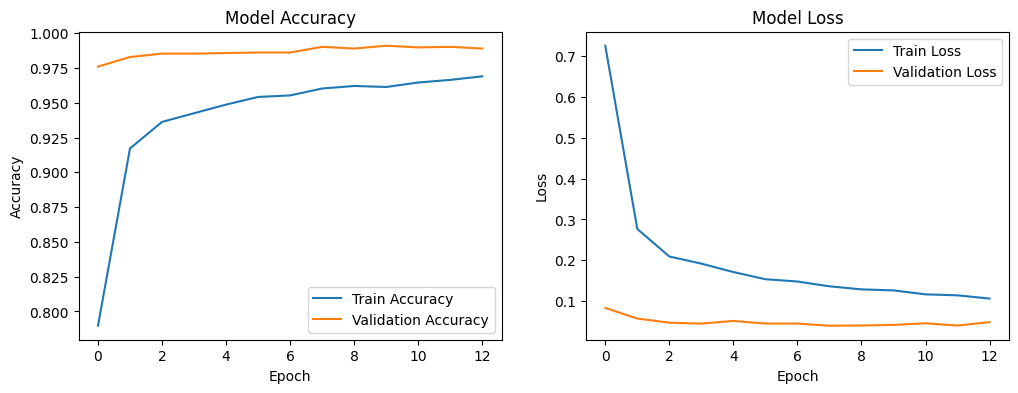

In [11]:
import matplotlib.pyplot as plt

# Tạo figure với kích thước 12x4
plt.figure(figsize=(12, 4))

# Biểu đồ accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Biểu đồ loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Hiển thị biểu đồ
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


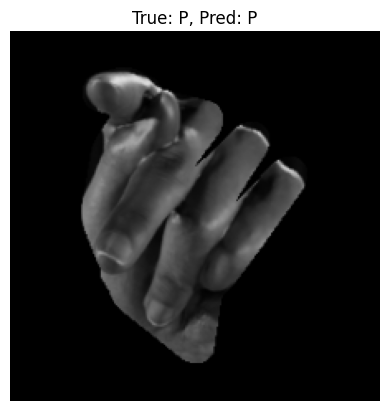

In [12]:
import random
import numpy as np
import string
import matplotlib.pyplot as plt

# Lấy một batch từ tập validation
val_images, val_labels = next(iter(val_ds))

# Chọn một ảnh ngẫu nhiên từ batch
random_index = random.randint(0, BATCH_SIZE - 1)
img = val_images[random_index]
true_label = val_labels[random_index]

# Dự đoán nhãn của ảnh
pred = model.predict(tf.expand_dims(img, axis=0))
pred_label = string.ascii_uppercase[np.argmax(pred)]
true_label_str = string.ascii_uppercase[np.argmax(true_label)]

# Hiển thị ảnh và nhãn
plt.imshow(img)
plt.title(f"True: {true_label_str}, Pred: {pred_label}")
plt.axis('off')  # Tắt trục để ảnh rõ hơn
plt.show()